In [1]:
import torch
words = (open('./dataset/data.txt','r')).read().splitlines()
print(len(words))

32033


In [4]:
words[:6]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte']

In [66]:
X = []
Y = []

def get(s):
    return (ord(s) - ord('a')) + 1

for word in words[:2000]:
    for i in range(len(word)):
        now = [0, 0, 0]
        now1 = 0
        now[1] = get(word[i])
        if(i - 1 >= 0):
            now[0] = get(word[i-1])
        if(i + 1 < len(word)):
            now[2] = get(word[i+1])
        if(i + 2 < len(word)):
            now1 = get(word[i+2])
        X.append(now)
        Y.append(now1)

print(X[:2])
#print(Y)

[[0, 5, 13], [5, 13, 13]]


In [67]:
# uff, we have the dataset, now we make preparations
g = torch.Generator().manual_seed(69*420)
C = torch.randn((27,2),generator=g,requires_grad=True) # this is the lookup table
C.shape

torch.Size([27, 2])

In [68]:
# we need to prepare it for processing by the hidden layer
# so we need to....?
# we need to linearise the data C[X] so that it is easier to play with
# we convert [36,3,2] to [36,6] by just putting all three things linearly
N = C[X].view(len(C[X]),-1)
N.shape

# I guess that's what was needed

torch.Size([12035, 6])

In [69]:
# The hidden layer just does a tanh and sends it forward to the softmax
W1 = torch.randn((6,100),generator=g,requires_grad=True)
B1 = torch.randn(100,generator=g,requires_grad=True)

print(N.shape)
print(W1.shape)
N = torch.tanh(N@W1 + B1)
print(N)

torch.Size([12035, 6])
torch.Size([6, 100])
tensor([[-0.5084,  0.9821,  0.9948,  ...,  0.8410,  0.9050, -0.9690],
        [ 0.3706, -0.5361,  0.9033,  ...,  0.3452,  0.9829, -0.9952],
        [-0.6352, -0.2983,  0.3272,  ...,  0.9990, -0.8990, -0.2820],
        ...,
        [-0.1802,  0.9958,  0.9993,  ...,  0.6687,  0.4977, -0.0753],
        [-1.0000, -0.9772, -0.9998,  ..., -1.0000,  0.9829, -0.9998],
        [-0.9878,  0.9774, -0.2187,  ...,  0.9869, -0.9753,  0.9998]],
       grad_fn=<TanhBackward0>)


In [70]:
N.shape

torch.Size([12035, 100])

In [71]:
# softmax layer, we get [36,100] from last layer
# we must return a single layer of size 26 with the probabilities of all chars
W2 = torch.randn((100,27),generator=g,requires_grad=True)
B2 = torch.randn(27,generator=g,requires_grad=True)

logits = N@W2 + B2
counts = logits.exp() # remove the negative logits
probs = counts / counts.sum(1,keepdims=True)

probs

tensor([[3.4689e-10, 1.2802e-04, 2.3130e-05,  ..., 4.5349e-01, 3.2673e-04,
         5.0097e-07],
        [7.6284e-10, 1.0355e-02, 2.0179e-02,  ..., 6.5103e-01, 2.4623e-04,
         2.7340e-08],
        [4.6093e-05, 3.9172e-06, 9.9161e-01,  ..., 1.0914e-10, 3.8243e-05,
         3.6075e-08],
        ...,
        [1.6829e-22, 1.7216e-17, 2.7303e-15,  ..., 7.0792e-12, 3.1246e-10,
         1.0966e-11],
        [1.0614e-04, 7.2293e-05, 3.2279e-01,  ..., 4.0338e-02, 4.1019e-09,
         5.9438e-10],
        [1.7697e-06, 5.3031e-11, 2.9182e-03,  ..., 5.6724e-12, 8.2922e-10,
         1.3284e-07]], grad_fn=<DivBackward0>)

In [72]:
# now we have the final probabilities for each input?, oh wait, its all random right now, we need to train it
# but how do
# the idea is: with a neural network, we are just processing the probabilities, we get what we put in
# its totally random right now, but I need to train it
# but how do I get the output of the things I put in ?
# we have already put in the things that we need to find the probablities of
# how th find em ?
# the things is, we need to find the log likelihood of the expected ouputs with a given input
# and we just have to optimize for that
# okayyy

tensor(15.6360, grad_fn=<NegBackward0>)
2.0697872638702393


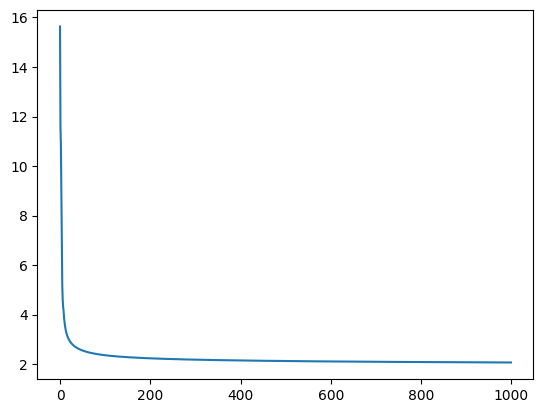

In [73]:
iterations = []
losses = []
import matplotlib.pyplot as plt

decay_rate = 0.26
learning_rate = 1.55
current_rate = 1.55

def get_loss(probs):
    likelihood = 0
    for i in range(len(X)):
        pro = probs[i, Y[i]]
        likelihood += torch.log(pro)
    likelihood /= len(X)
    loss = -likelihood
    return loss


def reset_grads():
    if W1.grad is not None:
        W1.grad.zero_()
    if W2.grad is not None:
        W2.grad.zero_()
    if B1.grad is not None:
        B1.grad.zero_()
    if B2.grad is not None:
        B2.grad.zero_()
    if C.grad is not None:
        C.grad.zero_()

def gradient_descent():
    W1.data -= current_rate * W1.grad
    W2.data -= current_rate * W2.grad
    B1.data -= current_rate * B1.grad
    B2.data -= current_rate * B2.grad
    C.data -= current_rate * C.grad

def update_probs():
    N = C[X].view(len(C[X]), -1)
    N = torch.tanh(N @ W1 + B1)
    logits = N @ W2 + B2
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    return probs

# init loss
print(get_loss(probs))

# Training loop
for descent in range(1000):
    loss = get_loss(probs)

    # Reset gradients
    reset_grads()

    loss.backward()

    gradient_descent()

    current_rate = learning_rate * (1 / (1 + descent*decay_rate))

    probs = update_probs()

    iterations.append(descent)
    losses.append(loss.item())

    #print(loss.item())

plt.plot(iterations,losses)
print(loss.item())

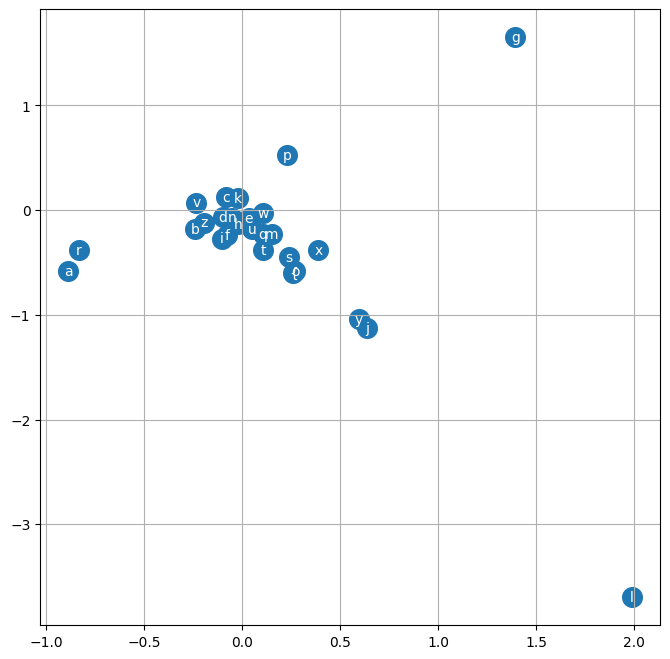

In [80]:
def get(i):
    if i < 0 or i > 26:
        return '.'
    else:
        return chr(ord('a') + i)

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), get(i), ha="center", va="center", color='white')
plt.grid('minor')